# Explore results and generate graphs

In [39]:
# Global imports, constants
import os
import ast
import pandas as pd
import pickle
import seaborn as sns
from scipy.stats import f_oneway
import matplotlib.pyplot as plt

from power_calculator import calculate_power
from scrape_cardlists import DATA_PATH

DECKS = os.path.join(DATA_PATH, "decks")
DOCS = os.path.abspath(os.path.join('..', 'docs'))

DECK_TYPES = ["cos_sim", "edhrec", "manual_rand", "edh-llm"]

## Power Heuristic

### Load data

In [19]:

# Parse power level from deck file
def compile_power(directory):
    data = []  # To hold dictionaries from files
    for root, dirs, files in os.walk(directory):
        folder_name = os.path.basename(root)  # Get the current folder name
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(root, file)
                #print(file_path)
                with open(file_path, 'r+', encoding='utf-8', errors='ignore') as f:
                    lines = f.readlines()
                    if lines:
                        try:
                            # Convert the last line to a dictionary
                            last_line_dict = ast.literal_eval(lines[-1].strip())
                            # Ensure it's actually a dictionary
                            if isinstance(last_line_dict, dict):
                                last_line_dict['folder'] = folder_name  # Add folder name to the dictionary
                                last_line_dict['commander'] = file
                                if (last_line_dict['cmc'] == 0):
                                    last_line_dict['cmc'] = 3
                                last_line_dict['overall'] = 2 / float(last_line_dict['cmc']) + ( int(last_line_dict['draw'])/2 + int(last_line_dict['ramp'])/2) / 2 + int(last_line_dict['interaction'])/20
                                data.append(last_line_dict)
                                lines[-1] = str(last_line_dict)
                                f.seek(0)
                                f.writelines(lines)
                        except (ValueError, SyntaxError):
                            print(f"Error processing file: {file_path}")
                            continue
    return pd.DataFrame(data)

df = compile_power(DECKS)
for col in df:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        pass

df.head()

,overall,cmc,ramp,draw,interaction,folder,commander
0,17.471311,2.772727,32,35,0,baseline,AesiTyrantofGyreStrait.txt
1,1.284071,3.424242,1,0,9,baseline,AgrusKosEternalSoldier.txt
2,1.305837,3.953846,1,2,1,baseline,AkromaVisionofIxidor.txt
3,7.880612,3.769231,2,26,7,baseline,AlandraSkyDreamer.txt
4,8.996218,3.661538,4,29,4,baseline,AotheDawnSky.txt


In [30]:
# save parsed data to pickle
df.to_pickle(os.path.join(DATA_PATH,'power.pkl'))

### Plot graphs

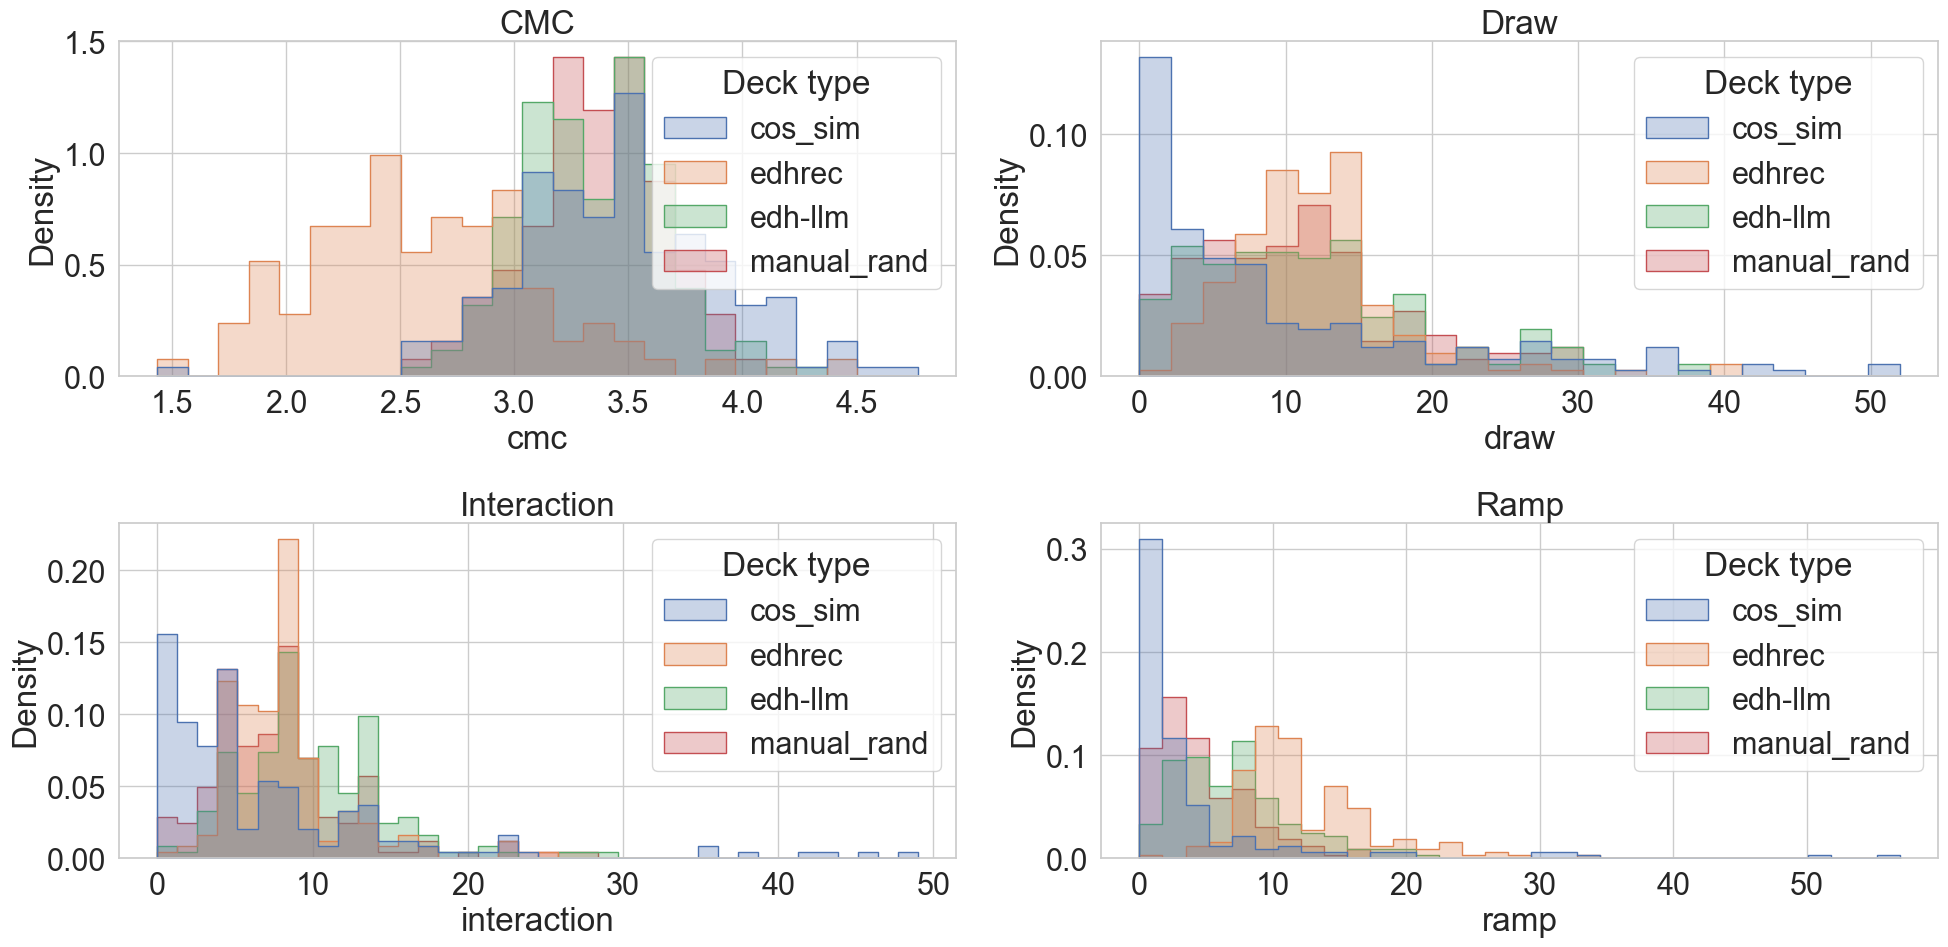

In [80]:
# Plot graphs for each power heuristic component
POWER_TITLES = {
    'cmc': 'CMC',
    'draw': 'Draw',
    'ramp': 'Ramp',
    'interaction': 'Interaction',
    'overall': 'Overall'
}

# Set the aesthetic style of the plots
sns.set(style="whitegrid", font_scale=2)
plt.figure(figsize=(20, 10))

# Don't consider unnecessary columns
df.columns = df.columns.str.replace('folder', 'Deck type')
columns = df.columns.difference(['Deck type', 'overall', 'commander'])

# Plotting
for i, column in enumerate(columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data=df, x=column, hue="Deck type", element="step", stat="density", common_norm=False, alpha=0.3)
    plt.title(f'{POWER_TITLES[column]}')
plt.tight_layout()
plt.savefig(os.path.join(DOCS, 'power_distributions.png'))
plt.show()

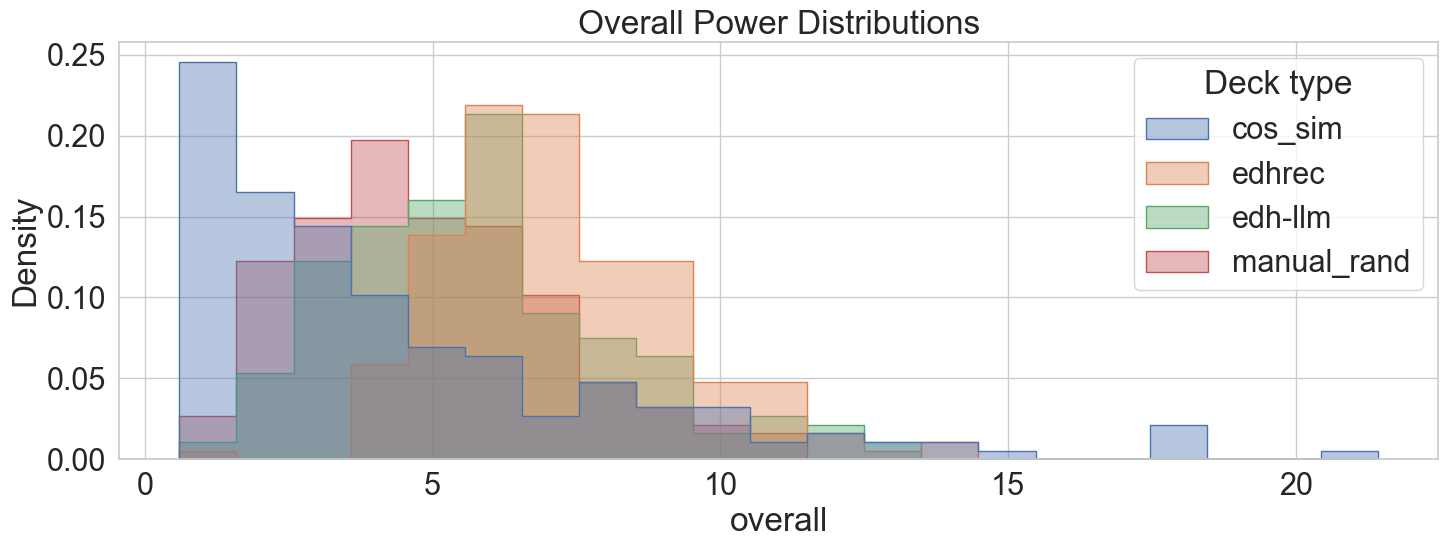

In [81]:
# Plot graphs for the overall power heuristic

# Calculate appropriate bin edges to cover the full range of data without gaps
bin_edges = range(int(df['overall'].min()), int(df['overall'].max()) + 2)  # +2 to ensure the last data point is included

plt.figure(figsize=(15, 6))  # Adjust size as needed
sns.histplot(data=df, x='overall', hue='Deck type', binwidth=1, bins=bin_edges, stat="density", element="step", common_norm=False, alpha=0.4)
plt.title('Overall Power Distributions')
plt.tight_layout()
plt.savefig(os.path.join(DOCS, 'power_overall.png'))
plt.show()

### Statistical analysis/EDA

In [20]:
# view mean power scores for each deck type
df.drop(columns='commander').groupby('folder').mean()

,overall,cmc,ramp,draw,interaction
folder,,,,,
cos_sim,4.506141,3.452893,3.994709,10.222222,7.222222
edhrec,7.247856,2.620288,12.243386,11.910053,8.322751
gpt,5.819461,3.342160,7.058201,11.804233,10.005291
manual_rand,4.904552,3.354173,4.640212,10.968254,8.031746


In [26]:
# statistical analysis of results using ANOVA test

for col in df.columns.difference(['folder', 'commander']):
    # Similar setup as Kruskal-Wallis but for ANOVA
    data = [df[df['folder'] == folder][col] for folder in df['folder'].unique()]

    # Perform ANOVA
    stat, p = f_oneway(*data)

    print(col + ' Statistics= %.3f, p= %.3f' % (stat, p))
    if p > 0.05:
        print('Same means across all groups (fail to reject H0)')
    else:
        print('Different means across some groups (reject H0)')

cmc Statistics= 168.703, p= 0.000
Different means across some groups (reject H0)
draw Statistics= 1.732, p= 0.159
Same means across all groups (fail to reject H0)
interaction Statistics= 7.679, p= 0.000
Different means across some groups (reject H0)
overall Statistics= 36.569, p= 0.000
Different means across some groups (reject H0)
ramp Statistics= 88.757, p= 0.000
Different means across some groups (reject H0)


## Synergy Heuristic

### Load data

In [82]:
# Load the synergy data
decks = {}
syn_dfs = []
for deck_type in DECK_TYPES:
    deck_path = os.path.join(DECKS, deck_type)
    synergy_path = os.path.join(deck_path, 'synergy.pkl')
    with open(synergy_path, 'rb') as f:
        syn_dict = pickle.load(f)
    deck_syn = pd.DataFrame(syn_dict).T.reset_index(names='commander')
    deck_syn['Deck type'] = deck_type
    syn_dfs.append(deck_syn)

syn_df = pd.concat(syn_dfs, ignore_index=True)

syn_df.head()

,commander,commander_synergy,card_synergy,Deck type
0,"Aesi, Tyrant of Gyre Strait",-14.602552,-16.478460,cos_sim
1,"Agrus Kos, Eternal Soldier",-15.286592,-16.343018,cos_sim
2,"Akroma, Vision of Ixidor",-10.173688,-13.875167,cos_sim
3,"Alandra, Sky Dreamer",-14.854253,-17.140605,cos_sim
4,"Ao, the Dawn Sky",-14.333017,-15.660963,cos_sim


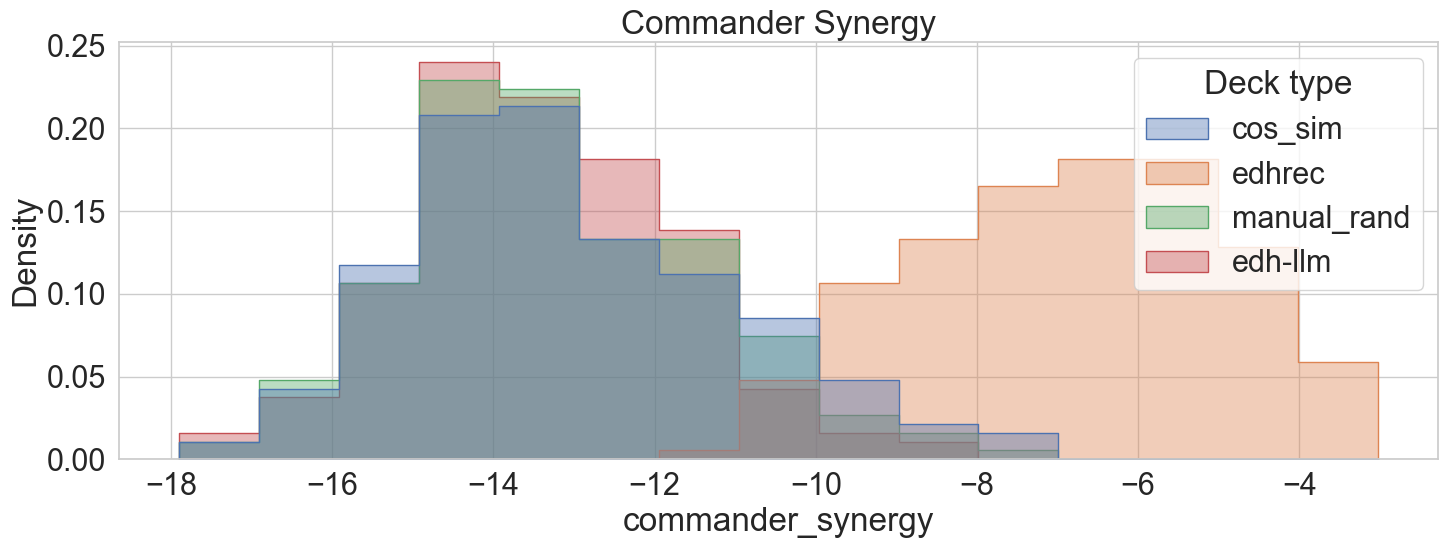

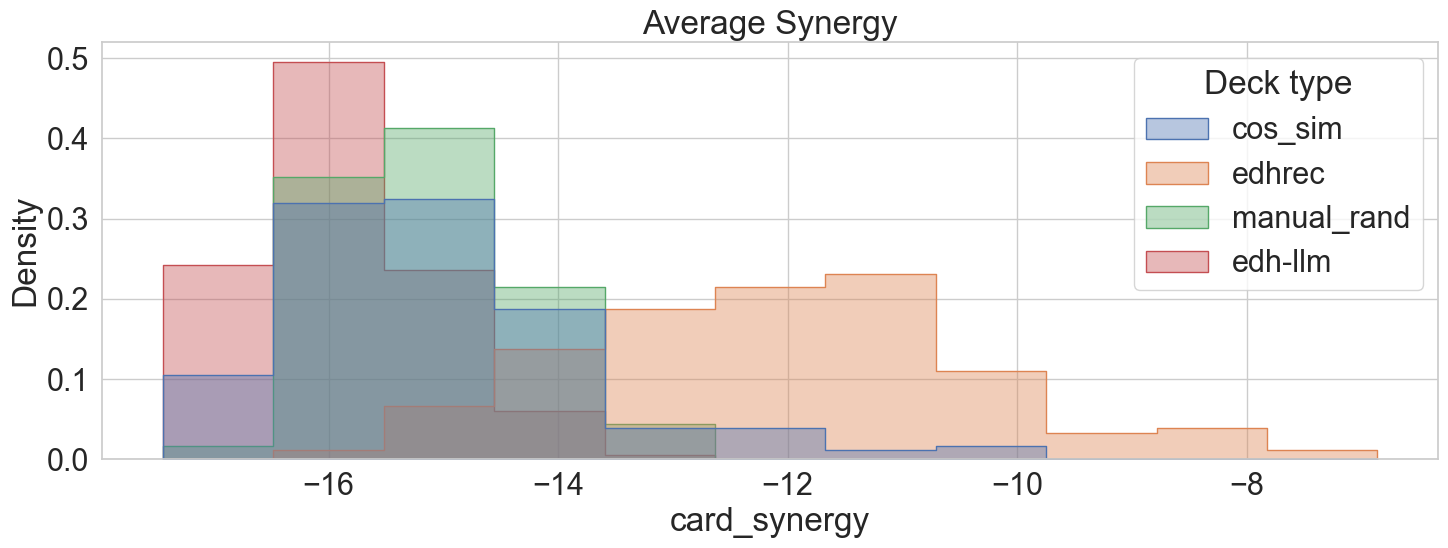

In [83]:
SYN_TITLES = {'commander_synergy':'Commander Synergy','card_synergy':'Average Synergy'}
for syn in SYN_TITLES.keys():
    # create histogram comparing the four deck types
    bin_edges = range(int(syn_df[syn].min()), int(syn_df[syn].max()) + 2)  # +2 to ensure the last data point is included
    plt.figure(figsize=(15, 6))  # Adjust size as needed
    sns.histplot(data=syn_df, x=syn, hue='Deck type', binwidth=1, bins=bin_edges, stat="density", element="step", common_norm=False, alpha=0.4)
    plt.title(SYN_TITLES[syn])
    plt.tight_layout()
    plt.savefig(os.path.join(DOCS, f'{syn}_histogram.png'))
    plt.show()